Préparation de l'environnement de travail

In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

In [60]:
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)

from sklearn import __version__ as sklearn_version
print("scikit-learn version:", sklearn_version)

pandas version: 2.2.2
numpy version: 1.26.4
matplotlib version: 3.9.2
seaborn version: 0.13.2
scikit-learn version: 1.5.1


Chargement et exploration des données

In [61]:
data = pd.read_csv("./billets.csv", sep=";")

In [62]:
# Afficher les premières lignes
display(data.head())

# Informations sur le dataset
display(data.info())

# Statistiques descriptives
display(data.describe())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


None

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [63]:
# Vérifier les valeurs manquantes
print(data.isnull().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


is_genuine
True     1000
False     500
Name: count, dtype: int64


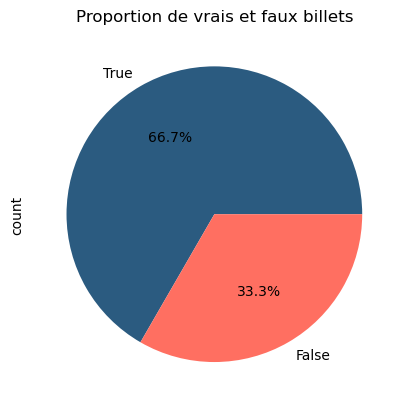

In [64]:
print(data['is_genuine'].value_counts())
data['is_genuine'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#2B5B80', '#FF6F61'])
plt.title("Proportion de vrais et faux billets")
plt.show()

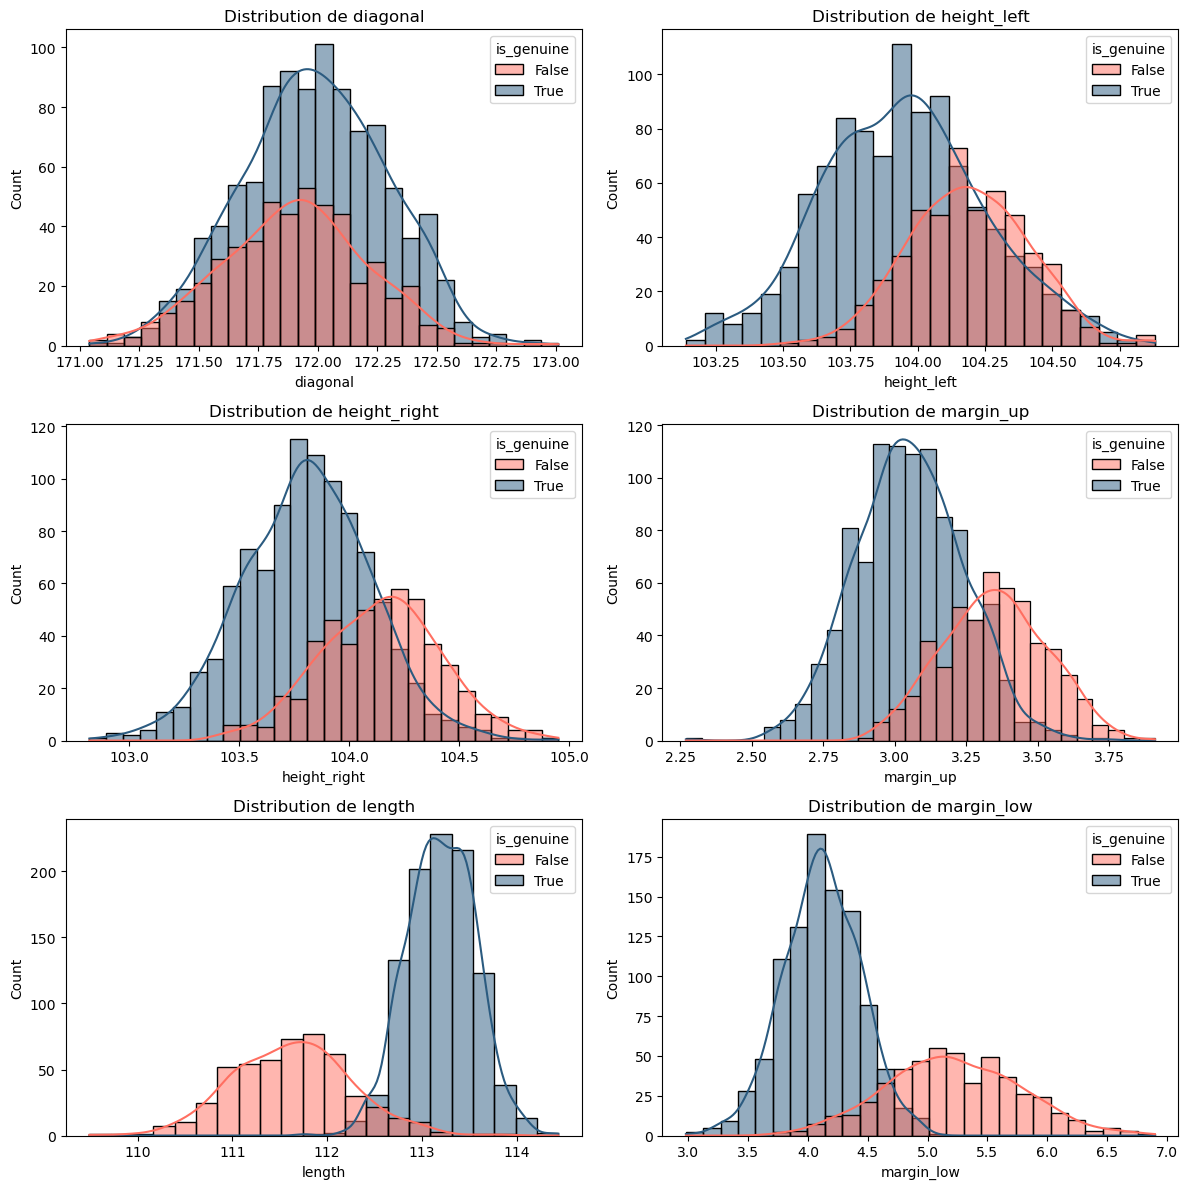

In [65]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12)) 
axes = axes.flatten()  # Aplatit la matrice d'axes pour faciliter l'accès
variables = ['diagonal', 'height_left','height_right','margin_up','length','margin_low']

for i, variable in enumerate(variables):
    sns.histplot(data, x=variable, hue='is_genuine', kde=True, ax=axes[i], palette=['#FF6F61','#2B5B80'])
    axes[i].set_title(f"Distribution de {variable}")

plt.tight_layout()  
plt.show()

In [66]:
# Commençons par changer le bool par du binaire pour la colonne is_genuine
data["is_genuine"].replace([True, False], [1,0], inplace=True)

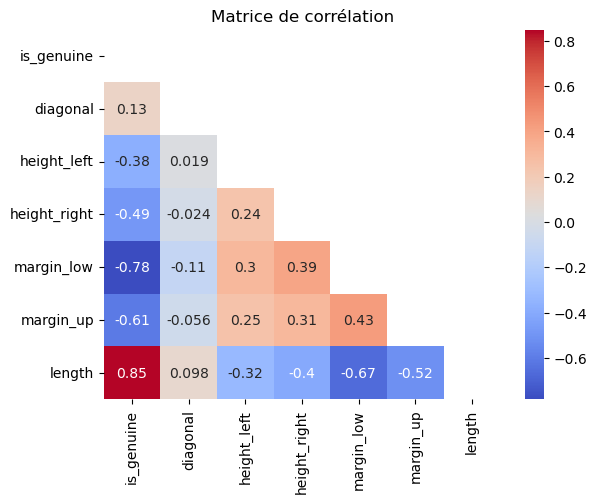

In [67]:
data_corr = data.corr()
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(), annot=True, mask=mask, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

Prétraitement des données

In [68]:
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


SCALER

In [69]:
# On crée une copie des données sans "is_genuine"
data_to_scale = data.drop(columns=['is_genuine'])

# Initialisation du StandardScaler
scaler = StandardScaler()

# Appliquer la normalisation sur les colonnes à scaler
data_scaled = scaler.fit_transform(data_to_scale)

# Convertir les données normalisées en DataFrame tout en réintégrant la colonne 'is_genuine'
data_scaled = pd.DataFrame(data_scaled, columns=data_to_scale.columns)

# Réintégrer "is_genuine" dans les données normalisées
data_scaled['is_genuine'] = data['is_genuine'].values

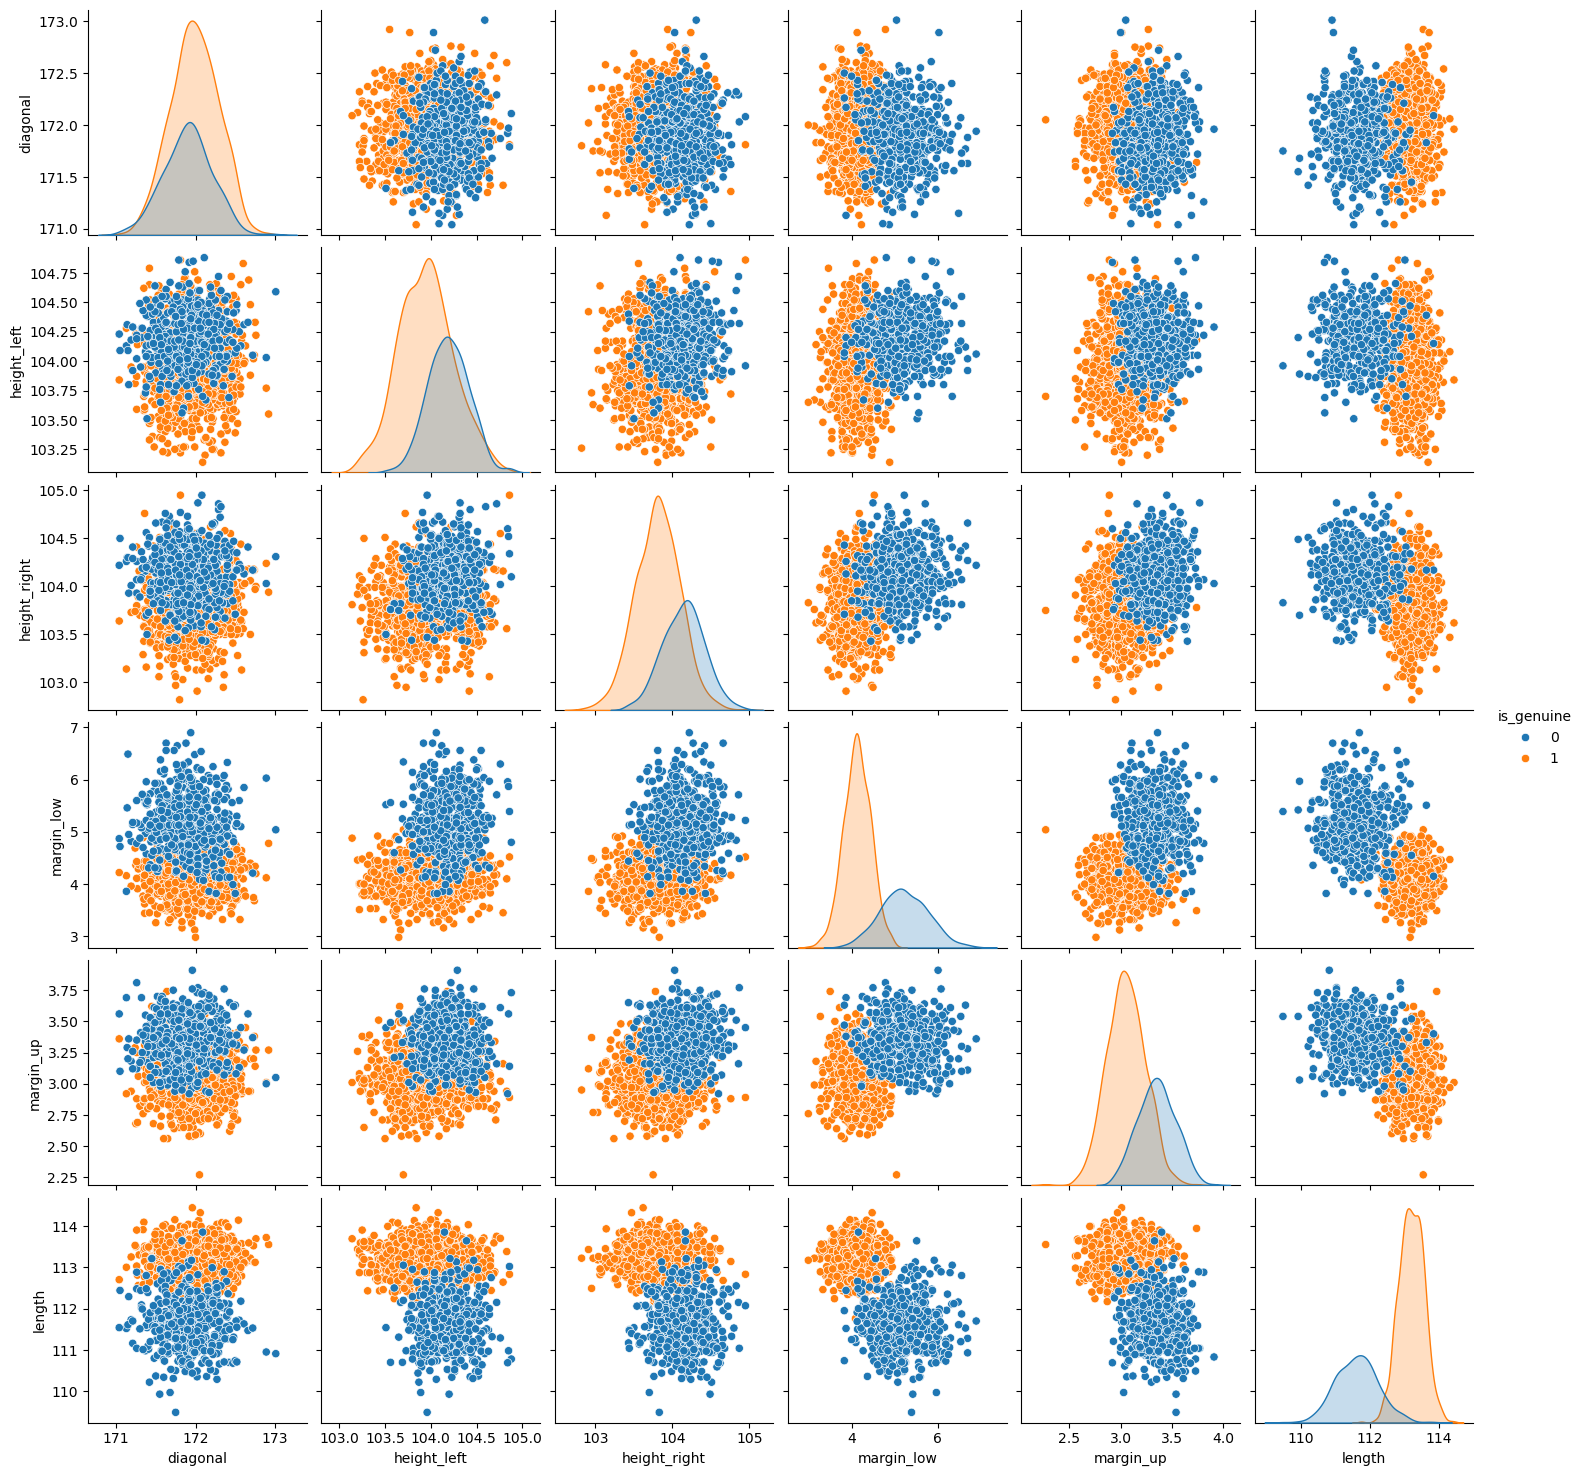

In [70]:
sns.pairplot(data, hue = 'is_genuine')

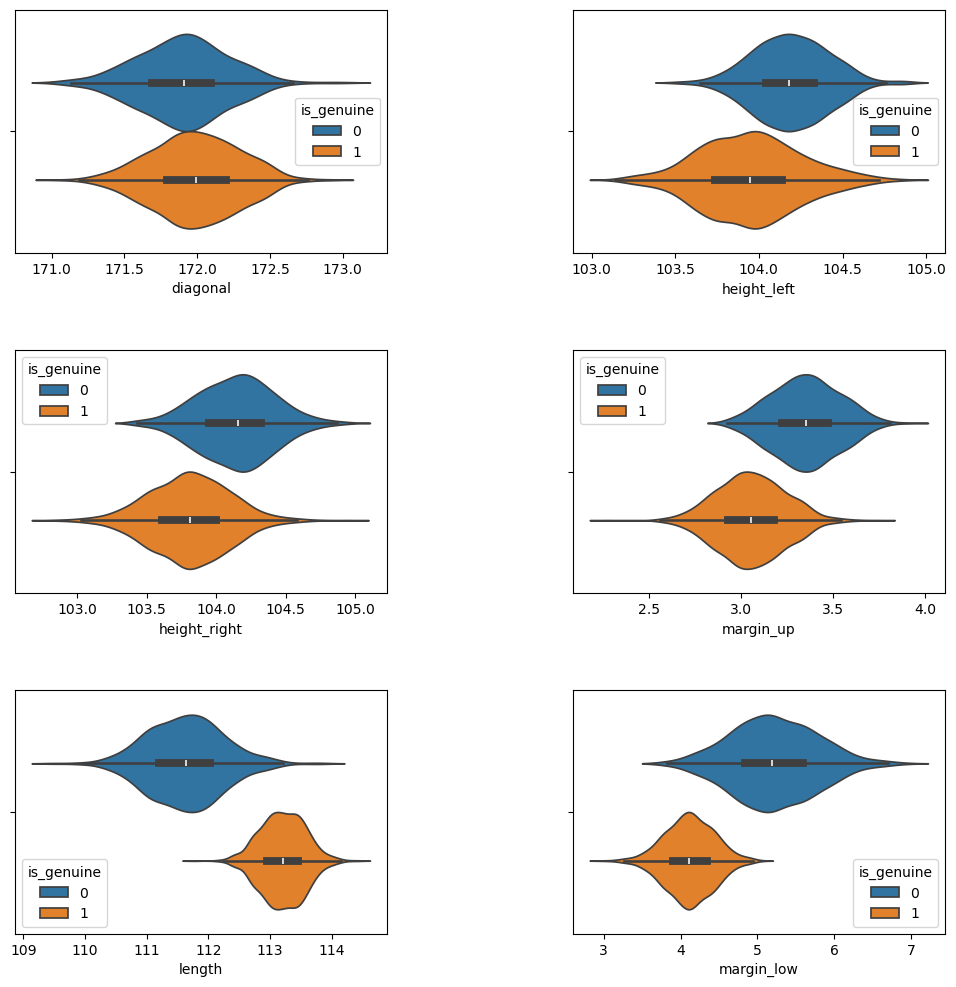

In [71]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.4)
axes = axes.flatten()  # Aplatit la matrice d'axes pour faciliter l'accès
variables = ['diagonal', 'height_left','height_right','margin_up','length','margin_low']
for i, variable in enumerate(variables):
    sns.violinplot(data, x=variable, ax=axes[i], hue= 'is_genuine')

In [72]:
# Regression linéaire pour les données manquantes

In [73]:
# Séparer les données complètes et les données vides
df_complete = data_scaled.dropna(subset=['margin_low'])
df_missing = data_scaled[data_scaled['margin_low'].isnull()]

In [74]:
'''
# Variables indépendantes
['diagonal', 'height_left','height_right','margin_up','length','is_genuine'] 
'''

"\n# Variables indépendantes\n['diagonal', 'height_left','height_right','margin_up','length','is_genuine'] \n"

In [75]:
import statsmodels.formula.api as smf

# Démarre avec toutes les colonnes possibles (sauf la variable cible)
remaining = set(['diagonal', 'is_genuine', 'height_left', 'height_right', 'margin_up', 'length'])
response = 'margin_low'
cond = True

# Boucle jusqu'à ce que toutes les p-values soient < 0.05 (valeurs non significatives)
while remaining and cond:
    # Crée la formule de régression linéaire
    formula = "{} ~ {} + 1".format(response, ' + '.join(remaining))
    print('_______________________________')
    print(formula)
    
    # Ajuste le modèle
    model = smf.ols(formula, data=df_complete).fit()
    
    # Obtiens les p-values des variables (on ignore l'intercept)
    pvalues = model.pvalues[1:]  # ignore intercept
    
    # Trouve la variable avec la plus grande p-value
    to_remove = pvalues.idxmax()  # variable avec la plus grande p-value
    max_pvalue = pvalues.max()  # la plus grande p-value
    
    # Si la plus grande p-value est supérieure à 0.05, on la supprime
    if max_pvalue > 0.05:
        print(f"Removing {to_remove} (p-value = {max_pvalue})")
        remaining.remove(to_remove)
    else:
        cond = False
        print("Final model !!!")
        
    print(model.summary())
    print('')


_______________________________
margin_low ~ margin_up + height_left + length + height_right + diagonal + is_genuine + 1
Removing length (p-value = 0.8684506945585388)
                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:              dim., 13 oct. 2024   Prob (F-statistic):          4.75e-299
Time:                        13:50:32   Log-Likelihood:                -1374.1
No. Observations:                1463   AIC:                             2762.
Df Residuals:                    1456   BIC:                             2799.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err        

In [76]:
# Définir les variables X (indépendantes) et y (dépendante)
X_complete = df_complete[['margin_up','is_genuine']]  # Variables indépendantes
y_complete = df_complete['margin_low']  # Variable dépendante

In [77]:
X_complete_train, X_complete_test, y_complete_train, y_complete_test = train_test_split(X_complete, y_complete, test_size=0.7, random_state=7, shuffle=True)

Verification des conditions pour la regression

In [78]:
# Model with statsmodels to check assumptions
X_with_const = sm.add_constant(X_complete_train)  # Add constant term for intercept
model = sm.OLS(y_complete_train, X_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     320.1
Date:              dim., 13 oct. 2024   Prob (F-statistic):           3.34e-86
Time:                        13:50:32   Log-Likelihood:                -417.51
No. Observations:                 438   AIC:                             841.0
Df Residuals:                     435   BIC:                             853.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1440      0.063     18.035      0.0

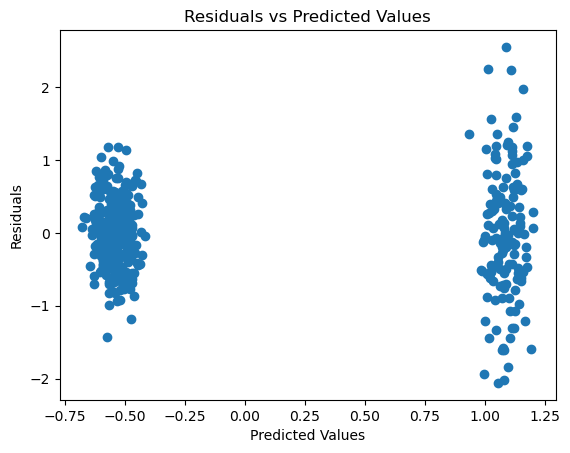

In [79]:
# 1. Linearity: Check the scatter plot of residuals vs predicted values
y_train_pred = model.predict(X_with_const)
plt.scatter(y_train_pred, model.resid)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

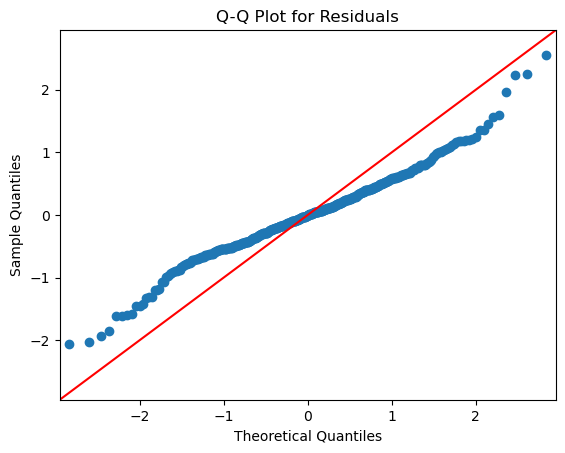

In [80]:
# 2. Normality of residuals
sm.qqplot(model.resid, line='45')
plt.title('Q-Q Plot for Residuals')
plt.show()

In [81]:
# 4. Independence of errors: Check Durbin-Watson statistic
print(f'Durbin-Watson: {model.summary().tables[2].data[3][1]}')

Durbin-Watson:  4.556


In [82]:
# 5. Multicollinearity: Calculate VIF for each feature

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_complete.columns
vif_data["VIF"] = [variance_inflation_factor(X_complete_train.values, i) for i in range(len(X_complete_train.columns))]
print(vif_data)

      feature       VIF
0   margin_up  1.134784
1  is_genuine  1.134784


In [83]:
X_complete

,margin_up,is_genuine
0,-1.128325,1
1,-0.696799,1
2,-0.912562,1
3,-0.610494,1
4,1.417677,1
...,...,...
1495,-0.265273,0
1496,0.942999,0
1497,0.899846,0
1498,1.331372,0


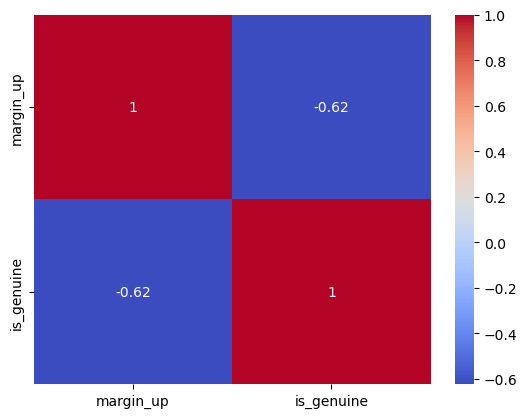

In [84]:
corr_matrix_train = X_complete_train.corr()
sns.heatmap(corr_matrix_train, annot=True, cmap='coolwarm')
plt.show()

Model de regression

In [85]:
regression = LinearRegression()
regression.fit(X_complete_train, y_complete_train)
y_pred = regression.predict(X_complete_test)

In [86]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_complete_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
# Calcul du coefficient de détermination (R²)
r2 = r2_score(y_complete_test, y_pred)
print(f"Coefficient de détermination (R²): {r2}")

Mean Squared Error (MSE): 0.3794364856834138
Coefficient de détermination (R²): 0.6247320065942108


<Axes: xlabel='margin_low'>

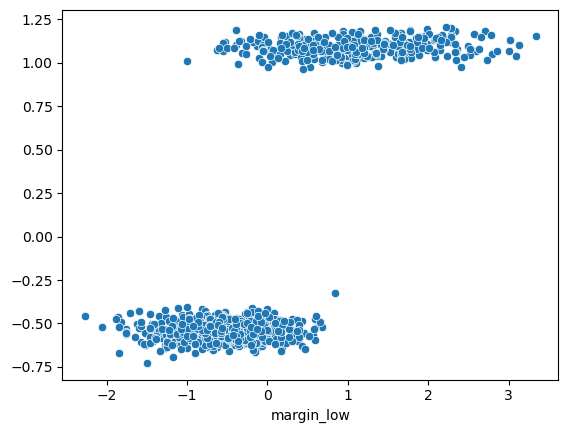

In [87]:
sns.scatterplot(x=y_complete_test,y= y_pred)

In [88]:
# Prédire les valeurs manquantes
X_missing = df_missing[['margin_up','is_genuine']]
predicted_margin_low = regression.predict(X_missing)

In [89]:
data_clean = data.copy()
data_clean.loc[data_clean['margin_low'].isnull(), 'margin_low'] = predicted_margin_low

Verifications des données

In [90]:
data_clean['is_genuine'].value_counts()

is_genuine
1    1000
0     500
Name: count, dtype: int64

Division des données en ensembles d'entraînement et de test

In [91]:
# Définir les caractéristiques
X = data_clean.drop('is_genuine', axis=1)

# Définir la cible
y = data_clean['is_genuine']

In [92]:
display(X.head())
display(y.head())

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


0    1
1    1
2    1
3    1
4    1
Name: is_genuine, dtype: int64

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y, shuffle=True)

In [94]:
print("Dimensions de X :", X.shape)
print("Dimensions de X_train :", X_train.shape)
print("Dimensions de X_test :", X_test.shape)

Dimensions de X : (1500, 6)
Dimensions de X_train : (1200, 6)
Dimensions de X_test : (300, 6)


In [95]:
print("Répartition des classes dans y_train :")
print(y_train.value_counts())

print("Répartition des classes dans y_test :")
print(y_test.value_counts())


Répartition des classes dans y_train :
is_genuine
1    800
0    400
Name: count, dtype: int64
Répartition des classes dans y_test :
is_genuine
1    200
0    100
Name: count, dtype: int64


Verifier le modèle de regression linéaire

In [96]:
# Entraîner le modèle
regression.fit(X_train, y_train)
# Faire des prédictions sur l'ensemble de test
y_pred = regression.predict(X_test)

In [97]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
# Calcul du coefficient de détermination (R²)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient de détermination (R²): {r2}")

Mean Squared Error (MSE): 0.043190416836847045
Coefficient de détermination (R²): 0.8056431242341883


Normalisation des données

standardisation aux données pour KNN

In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
print("Moyenne des caractéristiques après standardisation :")
print(X_train_scaled.mean(axis=0))

print("\nÉcart-type des caractéristiques après standardisation :")
print(X_train_scaled.std(axis=0))

Moyenne des caractéristiques après standardisation :
[ 3.20232729e-14 -1.70086167e-15  2.18077408e-14 -2.64973229e-16
 -2.28705943e-16  2.31074419e-15]

Écart-type des caractéristiques après standardisation :
[1. 1. 1. 1. 1. 1.]


Mise en place des modèles de machine learning

Régression logistique

In [100]:
# Initialiser le modèle et l'entrainer
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Lancer la prédiction
y_pred_logreg = logreg.predict(X_test_scaled)

In [101]:
#Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Exactitude de la régression logistique :", accuracy)

Exactitude de la régression logistique : 0.9833333333333333


Exactitude : Représente le pourcentage de prédictions correctes sur l'ensemble de test. Une valeur proche de 1 (ou 100%) indique une bonne performance globale.

In [102]:
#Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_logreg)
print("Matrice de confusion :\n", cm)

Matrice de confusion :
 [[ 96   4]
 [  1 199]]


In [103]:
#rapport de classification
cr = classification_report(y_test, y_pred_logreg)
print("Rapport de classification :\n", cr)

Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       100
           1       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



Kmeans


In [104]:
kmeans = KMeans(n_clusters=2, random_state=7)

In [105]:
#Entraîner le modèle sur l'ensemble d'entraînement
kmeans.fit(X_train_scaled)
#Effectuer des prédictions sur l'ensemble de test
y_pred_kmeans = kmeans.predict(X_test_scaled)

In [106]:
print(y_train.dtype)

int64


In [107]:
from scipy.stats import mode
# Mapper les clusters aux labels majoritaires
train_clusters = kmeans.labels_
cluster_labels = {cluster: y_train.iloc[np.where(train_clusters == cluster)].mode()[0]
                  for cluster in np.unique(train_clusters)}

# Mapper les clusters prédits aux labels réels
y_pred_kmeans_mapped = [cluster_labels[cluster] for cluster in y_pred_kmeans]

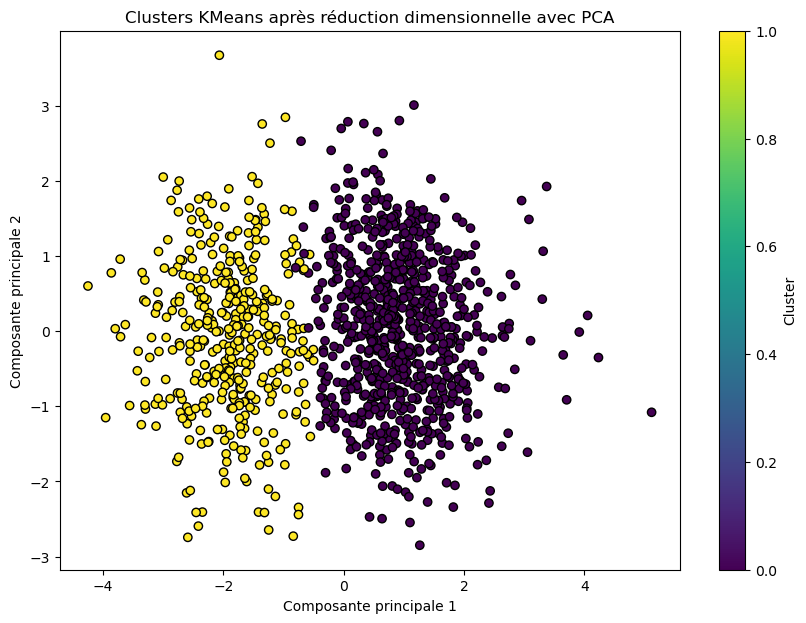

In [108]:
from sklearn.decomposition import PCA

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Obtenir les clusters prédits
kmeans_clusters = kmeans.predict(X_train_scaled)

# Visualiser les clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_clusters, cmap='viridis', marker='o', edgecolor='k')
plt.title("Clusters KMeans après réduction dimensionnelle avec PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(label="Cluster")
plt.show()

In [109]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_kmeans_mapped)
print("Exactitude du K-means :", accuracy)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_kmeans_mapped)
print("Matrice de confusion :\n", cm)

# Afficher le rapport de classification
cr = classification_report(y_test, y_pred_kmeans_mapped)
print("Rapport de classification :\n", cr)

Exactitude du K-means : 0.9733333333333334
Matrice de confusion :
 [[ 97   3]
 [  5 195]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       100
           1       0.98      0.97      0.98       200

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



KNN (K-Nearest Neighbors)

In [110]:
# Redéfinir et réentraîner le modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)  # Entraînement sur les données

# Vérifier les probabilités avec predict_proba
y_pred_knn = knn.predict(X_test_scaled)

# Vérifier les probabilités avec predict_proba
y_proba_knn = knn.predict_proba(X_test_scaled)

# Afficher les probabilités
print("Probabilités des classes (premières lignes) :")
print(y_proba_knn[:5])

# Extraire la colonne correspondant à la classe 1 (faux billets)
y_proba_class1 = y_proba_knn[:, 1]
print("Probabilités pour la classe 1 :")
print(y_proba_class1[:5])


Probabilités des classes (premières lignes) :
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Probabilités pour la classe 1 :
[1. 1. 1. 1. 1.]


In [111]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_knn)
print("Exactitude du KNN :", accuracy)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_knn)
print("Matrice de confusion :\n", cm)

# Afficher le rapport de classification
cr = classification_report(y_test, y_pred_knn)
print("Rapport de classification :\n", cr)


Exactitude du KNN : 0.9866666666666667
Matrice de confusion :
 [[ 96   4]
 [  0 200]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       100
           1       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



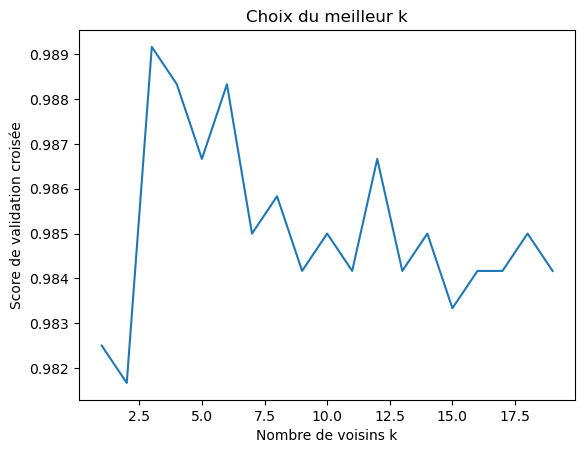

In [112]:
from sklearn.model_selection import cross_val_score

# Tester différents k
k_values = range(1, 20)
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    scores.append(knn_scores.mean())

# Tracer les scores
plt.plot(k_values, scores)
plt.xlabel('Nombre de voisins k')
plt.ylabel('Score de validation croisée')
plt.title('Choix du meilleur k')
plt.show()

Random Forest

In [113]:
rf = RandomForestClassifier(n_estimators=200, random_state=7)

In [114]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [115]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_rf)
print("Exactitude du Random Forest :", accuracy)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)
print("Matrice de confusion :\n", cm)

# Afficher le rapport de classification
cr = classification_report(y_test, y_pred_rf)
print("Rapport de classification :\n", cr)


Exactitude du Random Forest : 0.9866666666666667
Matrice de confusion :
 [[ 96   4]
 [  0 200]]
Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       100
           1       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



  Caractéristique  Importance
5          length    0.518495
3      margin_low    0.263524
4       margin_up    0.118143
2    height_right    0.058007
1     height_left    0.032315
0        diagonal    0.009517


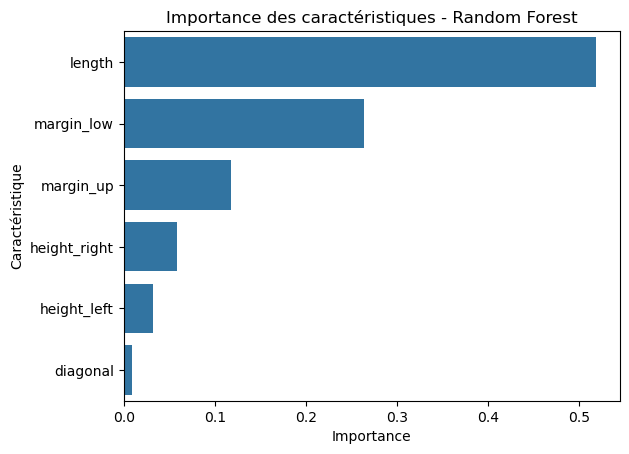

In [116]:
# Obtenir l'importance des caractéristiques
importances = rf.feature_importances_
feature_names = X_train.columns

# Créer un dataframe pour visualiser
feature_importance_df = pd.DataFrame({'Caractéristique': feature_names, 'Importance': importances})

# Trier les caractéristiques par importance décroissante
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Afficher les importances
print(feature_importance_df)

# Visualiser
sns.barplot(x='Importance', y='Caractéristique', data=feature_importance_df)
plt.title("Importance des caractéristiques - Random Forest")
plt.show()

Régression linéaire

In [117]:
lin_reg = LinearRegression()


In [118]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)
threshold = 0.5
y_pred_lin_class = np.where(y_pred_lin >= threshold, 1, 0)


In [119]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred_lin_class)
print("Exactitude de la régression linéaire :", accuracy)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_lin_class)
print("Matrice de confusion :\n", cm)

# Afficher le rapport de classification
cr = classification_report(y_test, y_pred_lin_class)
print("Rapport de classification :\n", cr)


Exactitude de la régression linéaire : 0.98
Matrice de confusion :
 [[ 95   5]
 [  1 199]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       100
           1       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



Rapport

In [120]:
# Régression logistique
print("Régression Logistique")
print(classification_report(y_test, y_pred_logreg))

# KNN
print("KNN")
print(classification_report(y_test, y_pred_knn))

# Random Forest
print("Random Forest")
print(classification_report(y_test, y_pred_rf))

# kmeans
print("kmeans")
print(classification_report(y_test, y_pred_kmeans_mapped))

Régression Logistique
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       100
           1       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

KNN
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       100
           1       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300

Random Forest
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       100
           1       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99 

Des essais de classification

Regression log

In [121]:
# Pour la classe 'True'
y_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

In [122]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.5, 1.0, 0.01)
for threshold in thresholds:
    y_pred_adjusted = (y_proba_logreg >= threshold)
    precision = precision_score(y_test, y_pred_adjusted, pos_label=True)
    recall = recall_score(y_test, y_pred_adjusted, pos_label=True)
    if precision == 1.0:
        print(f"Seuil: {threshold:.2f}, Précision: {precision:.2f}, Rappel: {recall:.2f}")


Seuil: 0.86, Précision: 1.00, Rappel: 0.94
Seuil: 0.87, Précision: 1.00, Rappel: 0.94
Seuil: 0.88, Précision: 1.00, Rappel: 0.94
Seuil: 0.89, Précision: 1.00, Rappel: 0.94
Seuil: 0.90, Précision: 1.00, Rappel: 0.93
Seuil: 0.91, Précision: 1.00, Rappel: 0.93
Seuil: 0.92, Précision: 1.00, Rappel: 0.93
Seuil: 0.93, Précision: 1.00, Rappel: 0.93
Seuil: 0.94, Précision: 1.00, Rappel: 0.92
Seuil: 0.95, Précision: 1.00, Rappel: 0.90
Seuil: 0.96, Précision: 1.00, Rappel: 0.86
Seuil: 0.97, Précision: 1.00, Rappel: 0.84
Seuil: 0.98, Précision: 1.00, Rappel: 0.82
Seuil: 0.99, Précision: 1.00, Rappel: 0.71


KNN

Random Forest

In [123]:
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [126]:
thresholds = np.arange(0.5, 1.0, 0.01)
for threshold in thresholds:
    y_pred_adjusted = (y_proba_rf >= threshold)
    precision = precision_score(y_test, y_pred_adjusted, pos_label=True)
    recall = recall_score(y_test, y_pred_adjusted, pos_label=True)
    if precision == 1.0:
        print(f"Seuil: {threshold:.2f}, Précision: {precision:.2f}, Rappel: {recall:.2f}")


Seuil: 0.89, Précision: 1.00, Rappel: 0.94
Seuil: 0.90, Précision: 1.00, Rappel: 0.94
Seuil: 0.91, Précision: 1.00, Rappel: 0.92
Seuil: 0.92, Précision: 1.00, Rappel: 0.92
Seuil: 0.93, Précision: 1.00, Rappel: 0.91
Seuil: 0.94, Précision: 1.00, Rappel: 0.90
Seuil: 0.95, Précision: 1.00, Rappel: 0.88
Seuil: 0.96, Précision: 1.00, Rappel: 0.86
Seuil: 0.97, Précision: 1.00, Rappel: 0.83
Seuil: 0.98, Précision: 1.00, Rappel: 0.80
Seuil: 0.99, Précision: 1.00, Rappel: 0.76


Optimisation du modele 

In [127]:
optimal_threshold_logreg = 0.94
y_pred_logreg_adjusted = (y_proba_logreg >= optimal_threshold_logreg)

print("Régression Logistique avec seuil ajusté à %.2f :" % optimal_threshold_logreg)
print(classification_report(y_test, y_pred_logreg_adjusted))

Régression Logistique avec seuil ajusté à 0.94 :
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       100
           1       1.00      0.92      0.96       200

    accuracy                           0.94       300
   macro avg       0.93      0.96      0.94       300
weighted avg       0.95      0.94      0.94       300



In [128]:
optimal_threshold_rf = 0.94
y_pred_rf_adjusted = (y_proba_rf >= optimal_threshold_rf)

print("Régression Logistique avec seuil ajusté à %.2f :" % optimal_threshold_rf)
print(classification_report(y_test, y_pred_rf_adjusted))

Régression Logistique avec seuil ajusté à 0.94 :
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       100
           1       1.00      0.90      0.95       200

    accuracy                           0.93       300
   macro avg       0.92      0.95      0.93       300
weighted avg       0.94      0.93      0.93       300



Detection avec un nouveau fichier

In [129]:
import joblib

# Créer un dictionnaire pour sauvegarder à la fois le modèle et le seuil
model_and_threshold = {
    'model': logreg,  
    'threshold': optimal_threshold_logreg 
}

joblib.dump(model_and_threshold, 'logreg_model.pkl')


['logreg_model.pkl']

In [130]:
# Créer un dictionnaire pour sauvegarder à la fois le modèle et le seuil
model_and_threshold = {
    'model': rf,  
    'threshold': optimal_threshold_rf 
}

joblib.dump(model_and_threshold, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [134]:
# Charger le nouveau fichier CSV
new_data = pd.read_csv("./billets_production.csv")

# Sélectionner les colonnes géométriques (sans la colonne cible)
X_new = new_data[['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal']]

# Appliquer le même scaler utilisé lors de l'entraînement
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)
# Appliquer le modèle pour faire des prédictions
y_pred_new = logreg.predict(X_new_scaled)

# Ajouter la prédiction au dataframe original pour visualiser
new_data['Prediction_is_genuine'] = y_pred_new

# Afficher les résultats
display(new_data[['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal', 'Prediction_is_genuine']].head())


,length,height_left,height_right,margin_up,margin_low,diagonal,Prediction_is_genuine
0,111.42,104.01,103.54,3.30,5.21,171.76,0
1,112.09,104.17,104.13,3.31,6.00,171.87,0
2,111.57,104.58,104.29,3.39,4.99,172.00,0
3,113.20,104.55,104.34,3.03,4.44,172.49,1
4,113.33,103.63,103.56,3.16,3.77,171.65,1


In [133]:
# Sélectionner les colonnes géométriques (sans la colonne cible)
X_new = new_data[['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal']]

# Appliquer le même scaler utilisé lors de l'entraînement
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)
# Appliquer le modèle pour faire des prédictions
y_pred_new = rf.predict(X_new_scaled)

# Ajouter la prédiction au dataframe original pour visualiser
new_data['Prediction_is_genuine'] = y_pred_new

# Afficher les résultats
display(new_data[['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal', 'Prediction_is_genuine']].head())

d:\Users\ZAPHAS\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,length,height_left,height_right,margin_up,margin_low,diagonal,Prediction_is_genuine
0,111.42,104.01,103.54,3.30,5.21,171.76,0
1,112.09,104.17,104.13,3.31,6.00,171.87,0
2,111.57,104.58,104.29,3.39,4.99,172.00,0
3,113.20,104.55,104.34,3.03,4.44,172.49,0
4,113.33,103.63,103.56,3.16,3.77,171.65,0
